In [346]:
# Directories
import os
os.chdir(r"E:\academy\OneDrive - IIT Delhi\3. IIT DELHI\2. Research\JRF\1_PAPER\2_Analysis")
print(os.getcwd())

E:\academy\OneDrive - IIT Delhi\3. IIT DELHI\2. Research\JRF\1_PAPER\2_Analysis


In [347]:
#Array packages
import cartopy.crs as ccrs
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nc4
from scipy.stats import kendalltau
import pymannkendall as mk

#plots
import matplotlib.pyplot as plt
import rioxarray as rio
import geopandas as gpd
from shapely.geometry import mapping
import cartopy.feature as cfeature
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.colors as mcolors
import scienceplots
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches  # For creating country legend handles
from matplotlib.patches import Circle
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.colors as mcolors
#Progress meter
from dask.diagnostics import ProgressBar
from tqdm import tqdm

# Directories
import os
import glob
import dask
#import h5netcdf
import scipy

#Trend
import xarrayMannKendall as XMK
import dask
from dask import delayed
import graphviz


from sklearn.preprocessing import StandardScaler
import numpy as np


# Styling and font settings
plt.rcParams["font.weight"] = "bold"
plt.rcParams["font.family"] = "Times New Roman"
plt.style.use('seaborn-white')

C:\Users\sstar\AppData\Local\Temp\ipykernel_13800\205620675.py:54: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


In [348]:
## REclassify LULC into increasing order

lulc1=xr.open_mfdataset('DATA_p\LULC\ESRI_LULC_reclassified.nc',engine='netcdf4', parallel=True,chunks={'time': 'auto'})
class_6= ['Built-up','Agricultural','Evergreen Broadleaf Forest','Shrubland/Wasteland','Water Bodeis','Ice-Glaciers']

## Again reclassified into 6 class for scn
my_class1 = {
    10: 4,  # Water -> 1
    20: 3,  # Trees -> 2
    30:1,    # Flooded Vegetation -> 3
    40: 2,  
    50: 6,  # Cropland -> 3 (Agricultural Land)
    60: 5,  

}

vec_fun=np.vectorize(my_class1.get)
a=vec_fun(lulc1['class_6'].values)
a = np.where(a == None, np.nan, a) 
a=a.astype(float)
a
lulc1['class_6_new'] = (('y', 'x'), a)


### 1 Correlation analysis

In [362]:

mdl=5
model=["LIS_MERRA2","LIS_IMD","LIS_CHIRPS","LIS_ERA5","LIS_IMDc","LIS_IMDcnew"]
sn=['Pre-monsoon', 'Monsoon', 'Post-monsoon', 'Winter']

var=['ppt','HSG','LULC']
res = pd.DataFrame(columns=var,index=sn)


## STEP 1 -Loading RE and precipitation data
lsm_M = xr.open_mfdataset(f'DATA_p/LIS/{model[mdl]}/{model[mdl]}_grid_ssn.nc',engine='netcdf4', parallel=True,chunks={'time': 'auto'})


## STEP 2- Load physiography data

soil=xr.open_mfdataset('DATA_p/Physiography/1_texture_classes.nc',engine='netcdf4', parallel=True,chunks={'time': 'auto'})

# Step 2: Check for and remove any duplicate index values (x and y)
lulc = lulc1.isel(x=~lulc1.get_index("x").duplicated(), y=~lulc1.get_index("y").duplicated())
soil = soil.isel(x=~soil.get_index("x").duplicated(), y=~soil.get_index("y").duplicated())


soil=soil.sel(y=lulc1.y.values,x=lulc1.x.values,method='nearest')
soil=soil.interp(x=lsm_avg.lon.values,y=lsm_avg.lat.values,method='nearest')
soil=soil.rename({'x':'lon','y':'lat'})

lulc=lulc.interp(x=lsm_avg.lon.values,y=lsm_avg.lat.values,method='nearest')
lulc=lulc.rename({'x':'lon','y':'lat'})

for s in sn:

    lsm_avg=lsm_M.sel(season=s).mean(dim='year')
    # Merge everythibng to one dataset
    data_ds=xr.Dataset({'RE':lsm_avg['RE'],'ppt':lsm_avg['TotalPrecip_tavg'],'HSG':soil['HSG_class'],'LULC':lulc['class_6_new']})


    # Subseting country
    data_ds=data_ds.sel(lat=slice(6,32),lon=slice(70,96))

    data_df=data_ds.to_dataframe()
    data=data_df.reset_index()
    data.drop(columns=['spatial_ref'],inplace=True)
    data=data.dropna()


    res.loc[s,'ppt']=np.corrcoef(data['RE'],data['ppt'])[0,1]
    res.loc[s,'HSG']=np.corrcoef(data['RE'],data['HSG'])[0,1]
    res.loc[s,'LULC']=np.corrcoef(data['RE'],data['LULC'])[0,1]


C:\Users\sstar\AppData\Local\Temp\ipykernel_13800\3289464573.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds', 3)  # Choose a colormap and number of colors


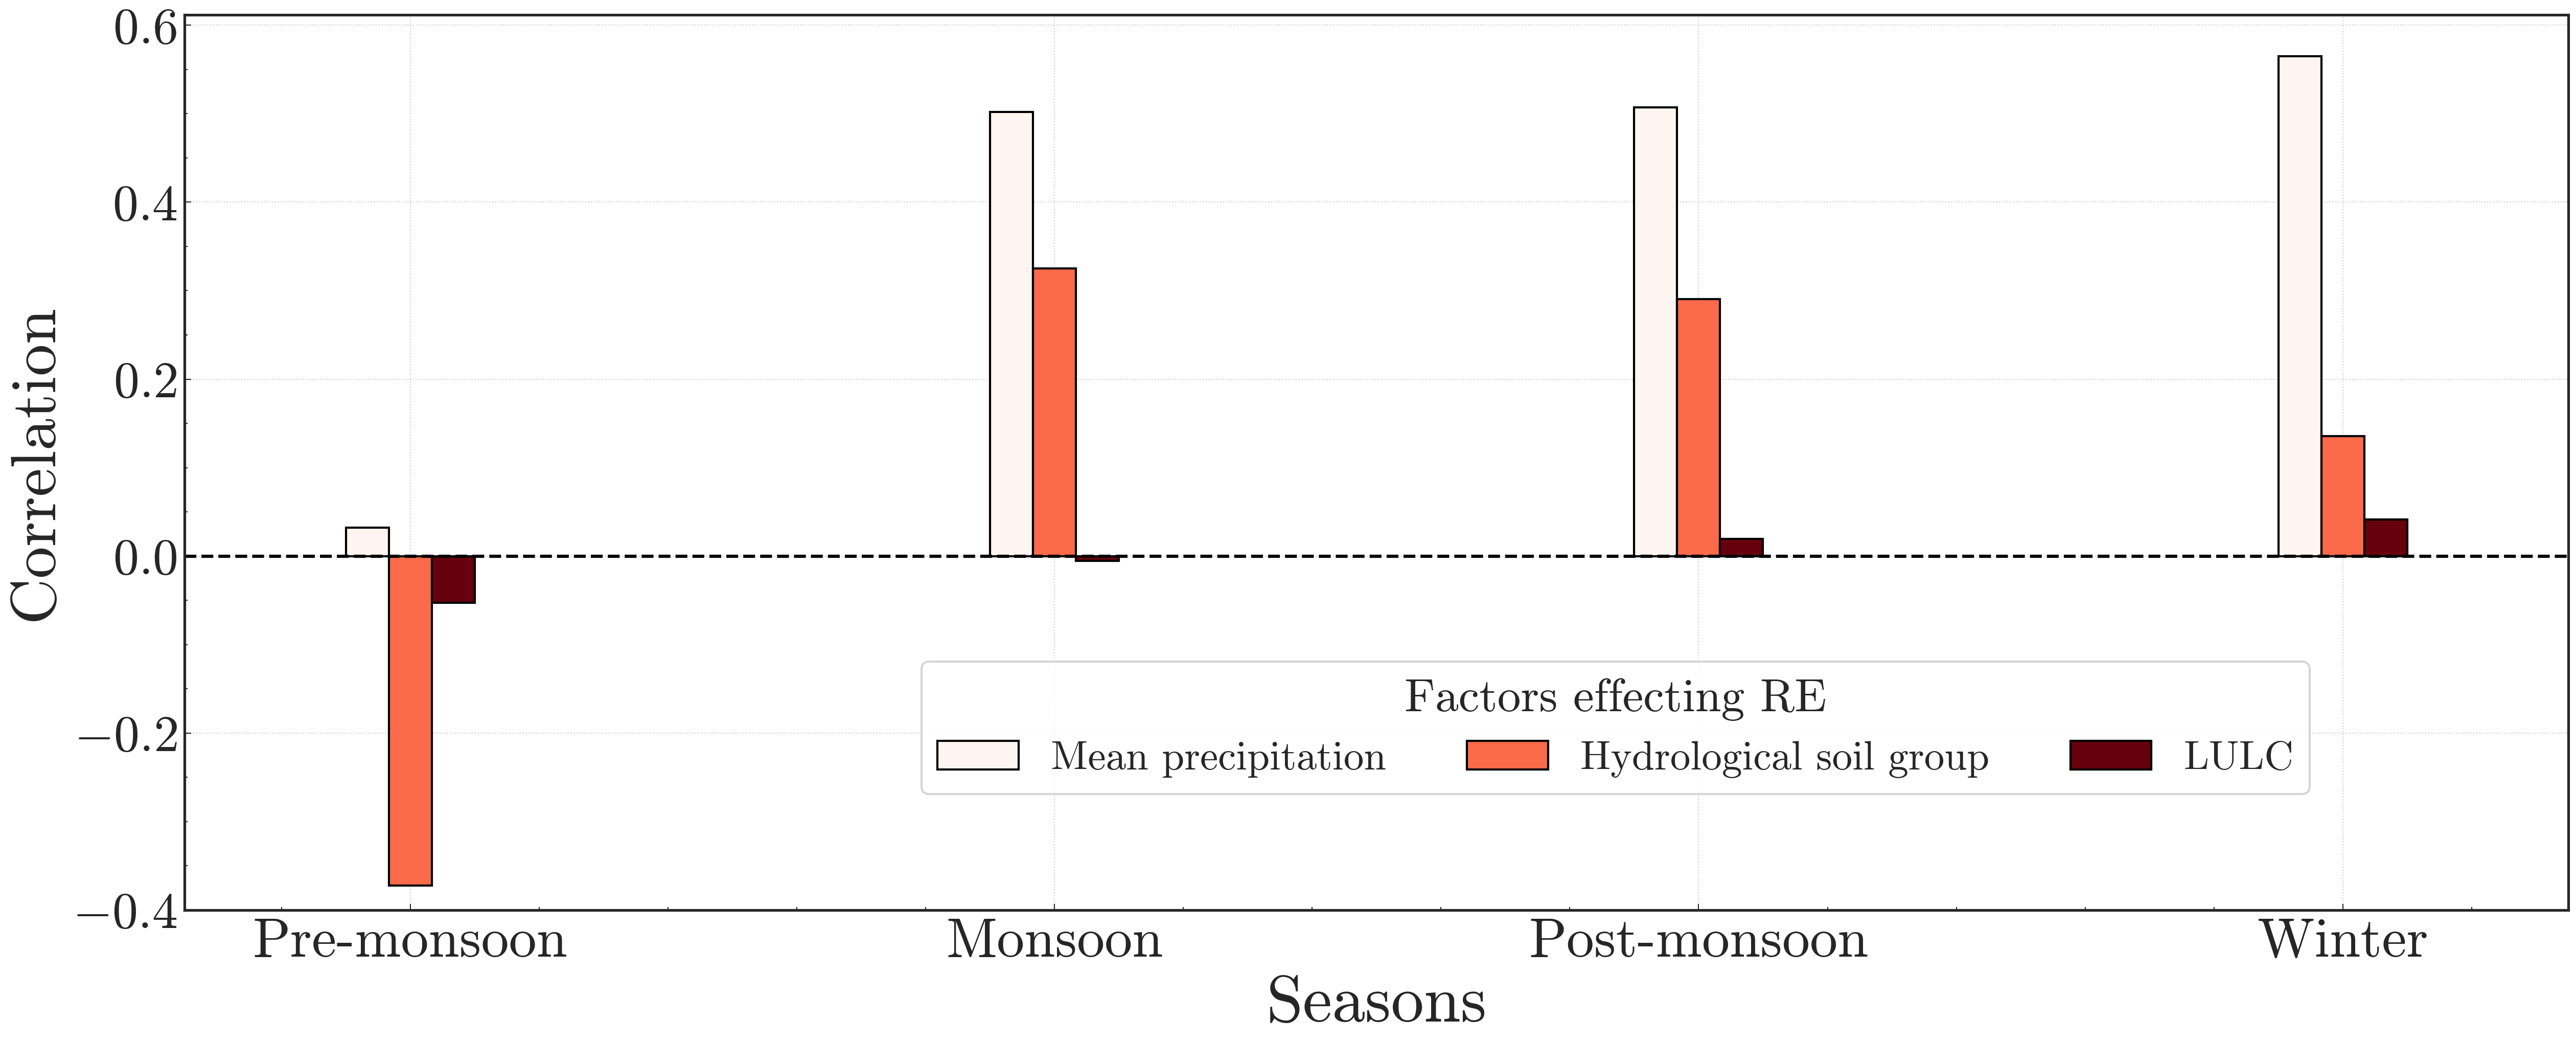

In [393]:
res.columns = ['Mean precipitation', 'Hydrological soil group', 'LULC']

## MAP
plt.style.use(['science','no-latex','bright'])

#Box plot of values
# Plotting bar plot with increased size
fig, ax = plt.subplots(figsize=(17, 7),dpi=300)  # Increased size

cmap = plt.cm.get_cmap('Reds', 3)  # Choose a colormap and number of colors
colors = [cmap(i) for i in range(3)] 
res.plot.bar(rot=0, ax=ax,color= colors,width=0.2,edgecolor='black')

[x.set_linewidth(1.25) for x in ax.spines.values()]
ax.grid(True, color= 'grey', alpha=0.4, linestyle='dotted')

ax.axhline(0, color='black', linewidth=1.5, linestyle='--')  # Line style and color can be customized

ax.set_ylim(-0.4)

#ax.set_title('Bar Plot of RE Values by Basin',fontsize=17)
ax.set_xlabel('Seasons',fontsize=31)
ax.set_ylabel('Correlation',fontsize=30)
ax.yaxis.set_tick_params(which='both', bottom=True, top=False,labelsize=24) 
ax.xaxis.set_tick_params(which='both', left=True, right=False,labelsize=26)

ax.legend(loc='upper right', bbox_to_anchor=(0.9, .3),title='Factors effecting RE',title_fontsize=22,ncol=3,fontsize=19,frameon=True)


plt.savefig('5_Physiographical Aspect/3_LULC.jpeg')
plt.tight_layout()

In [376]:
colors

[(1.0, 0.9607843137254902, 0.9411764705882353, 1.0),
 (0.984313725490196, 0.41568627450980394, 0.2901960784313726, 1.0),
 (0.403921568627451, 0.0, 0.05098039215686274, 1.0)]

### Multiple regresison

In [241]:

mdl=5
model=["LIS_MERRA2","LIS_IMD","LIS_CHIRPS","LIS_ERA5","LIS_IMDc","LIS_IMDcnew"]
sn=['Pre-monsoon', 'Monsoon', 'Post-monsoon', 'Winter']
sn=['Pre-monsoon']
res = pd.DataFrame(columns=X_var,index=sn)


## STEP 1 -Loading RE and precipitation data
lsm_M = xr.open_mfdataset(f'DATA_p/LIS/{model[mdl]}/{model[mdl]}_grid_ssn.nc',engine='netcdf4', parallel=True,chunks={'time': 'auto'})


## STEP 2- Load physiography data

soil=xr.open_mfdataset('DATA_p/Physiography/1_texture_classes.nc',engine='netcdf4', parallel=True,chunks={'time': 'auto'})

# Step 2: Check for and remove any duplicate index values (x and y)
lulc = lulc1.isel(x=~lulc.get_index("x").duplicated(), y=~lulc.get_index("y").duplicated())
soil = soil.isel(x=~soil.get_index("x").duplicated(), y=~soil.get_index("y").duplicated())


soil=soil.sel(y=lulc.y.values,x=lulc.x.values,method='nearest')
soil=soil.interp(x=lsm_avg.lon.values,y=lsm_avg.lat.values,method='nearest')
soil=soil.rename({'x':'lon','y':'lat'})

lulc=lulc.interp(x=lsm_avg.lon.values,y=lsm_avg.lat.values,method='nearest')
lulc=lulc.rename({'x':'lon','y':'lat'})

for s in sn:

    lsm_avg=lsm_M.sel(season=s).mean(dim='year')
    # Merge everythibng to one dataset
    data_ds=xr.Dataset({'RE':lsm_avg['RE'],'ppt':lsm_avg['TotalPrecip_tavg'],'HSG':soil['HSG_class'],'LULC':lulc['class_6_new']})


    # Subseting country
    data_ds=data_ds.sel(lat=slice(6,32),lon=slice(70,96))

    data_df=data_ds.to_dataframe()
    data=data_df.reset_index()
    data.drop(columns=['spatial_ref'],inplace=True)
    data=data.dropna()


    X_var=['ppt','LULC','HSG']
    X = data[X_var]  # Independent variables
    y = data['RE']  # Dependent variable

    # Standardize the independent variables
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Fit the model with standardized variables
    model_standardized = sm.OLS(y, sm.add_constant(X_scaled)).fit()

    r_sq=model_standardized.rsquared
    
    # Get standardized coefficients
    standardized_coeffs = model_standardized.params[1:]  # Exclude intercept
    standardized_coeffs = standardized_coeffs / np.sum(np.abs(standardized_coeffs))  # Normalize

    # Convert to percentage
    percentage_contribution = standardized_coeffs *r_sq* 100

    res.loc[s]=np.array(percentage_contribution)


                                 OLS Regression Results                                
Dep. Variable:                     RE   R-squared (uncentered):                   0.593
Model:                            OLS   Adj. R-squared (uncentered):              0.593
Method:                 Least Squares   F-statistic:                          1.847e+04
Date:                Sun, 27 Oct 2024   Prob (F-statistic):                        0.00
Time:                        16:20:47   Log-Likelihood:                          51164.
No. Observations:               38080   AIC:                                 -1.023e+05
Df Residuals:                   38077   BIC:                                 -1.023e+05
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [237]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Standardize the independent variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit the model with standardized variables
model_standardized = sm.OLS(y, sm.add_constant(X_scaled)).fit()

# Get standardized coefficients
standardized_coeffs = model_standardized.params[1:]  # Exclude intercept
standardized_coeffs = standardized_coeffs / np.sum(np.abs(standardized_coeffs))  # Normalize

# Convert to percentage
percentage_contribution = standardized_coeffs * 100

print("Percentage contribution of each factor:")
print(percentage_contribution)


Percentage contribution of each factor:
x1    46.66184
x2   -53.33816
dtype: float64
